## PySCF with OpenFermion

Oxygen bond length optimisation

Based on the examples from:

[https://github.com/quantumlib/OpenFermion-PySCF](https://github.com/quantumlib/OpenFermion-PySCF)

[https://quantumai.google/openfermion/tutorials](https://quantumai.google/openfermion/tutorials)

In [1]:
import io
from ase.io.xyz import write_xyz
from ase.visualize import view
from ase.build import molecule
atoms = molecule('O2')
view(atoms, viewer='x3d')

In [2]:
def create_molecule(bond_length: float):
    f = io.StringIO()
    atoms[0].c=0.
    atoms[1].c=bond_length
    atoms.write(f,format='xyz')
    return [(a.split()[0],(float(a.split()[1]),float(a.split()[2]),float(a.split()[3]))) for a in f.getvalue().split('\n')[2:-1]]


At bond length of 1.2 angstrom, molecular oxygen has:
Hartree-Fock energy of -147.5504389100643 Hartree.


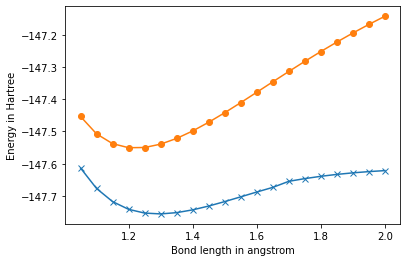

In [3]:
from openfermion.chem import MolecularData
from openfermionpyscf import run_pyscf

# Set molecule parameters.
basis = 'sto-3g'
multiplicity = 1
n_points = 20
bond_length_interval = 1.0 / n_points

# Set calculation parameters.
run_scf = 1
run_mp2 = 1
run_cisd = 0
run_ccsd = 0
run_fci = 1
delete_input = True
delete_output = True

# Generate molecule at different bond lengths.
hf_energies = []
fci_energies = []
bond_lengths = []
best_bond_length=None
best_hf_energy=None
for point in range(1, n_points + 1):
    bond_length = bond_length_interval * float(point) + 1.0
    bond_lengths += [bond_length]
    geometry = create_molecule(bond_length)
    molecule = MolecularData(
        geometry, basis, multiplicity,
        description=str(round(bond_length, 2)))
    
    # Run pyscf.
    molecule = run_pyscf(molecule,
                         run_scf=run_scf,
                         run_mp2=run_mp2,
                         run_cisd=run_cisd,
                         run_ccsd=run_ccsd,
                         run_fci=run_fci)

    # Print out some results of calculation.
    #print(f'\nAt bond length of {bond_length} angstrom, molecular oxygen has:')
    #print(f'Hartree-Fock energy of {molecule.hf_energy} Hartree.')
    #print(f'MP2 energy of {molecule.mp2_energy} Hartree.')
    #print(f'FCI energy of {molecule.fci_energy} Hartree.')
    #print(f'Nuclear repulsion energy between protons is {molecule.nuclear_repulsion} Hartree.')
    #for orbital in range(molecule.n_orbitals):
    #    print(f'Spatial orbital {orbital} has energy of {molecule.orbital_energies[orbital]} Hartree.')
    
    hf_energies += [molecule.hf_energy]
    fci_energies += [molecule.fci_energy]
    
    if not best_bond_length:
        best_bond_length = bond_length
        best_hf_energy = molecule.hf_energy
    elif best_hf_energy > molecule.hf_energy:
        best_hf_energy = molecule.hf_energy
        best_bond_length = bond_length
        

print(f'\nAt bond length of {best_bond_length} angstrom, molecular oxygen has:')
print(f'Hartree-Fock energy of {best_hf_energy} Hartree.')
        
# Plot.
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(0)
plt.plot(bond_lengths, fci_energies, 'x-')
plt.plot(bond_lengths, hf_energies, 'o-')
plt.ylabel('Energy in Hartree')
plt.xlabel('Bond length in angstrom')
plt.show()

In [4]:
o2_molecule=molecule
one_body_integrals=o2_molecule.one_body_integrals
one_body_integrals

array([[-3.37169097e+01, -9.29126483e-12,  9.06938646e-09,
        -6.24219355e-01,  1.53425612e-15, -4.74407155e-16,
        -1.32420603e-09, -3.88577695e-15,  8.05585393e-16,
         3.82855037e-02],
       [-9.28972601e-12, -3.37175320e+01,  6.06608805e-01,
         9.33226595e-09, -2.15959573e-15,  1.07817407e-15,
        -8.87171659e-02,  3.49723313e-15, -1.96731855e-16,
        -5.71497134e-10],
       [ 9.06938804e-09,  6.06608805e-01, -9.09226175e+00,
        -1.79728454e-12, -2.99916245e-16, -3.86078964e-16,
        -3.02977172e-01, -1.09584389e-15,  4.43689940e-15,
        -7.02882197e-12],
       [-6.24219355e-01,  9.33226759e-09, -1.79829762e-12,
        -9.00586023e+00, -4.31686997e-16, -1.15081190e-16,
        -4.30810942e-12, -5.28173629e-15,  1.11344765e-15,
         4.16940829e-01],
       [ 1.53425612e-15, -2.15959573e-15, -2.99916245e-16,
        -4.31686997e-16, -8.51595978e+00,  8.04689648e-13,
         4.11659541e-17, -2.66453526e-15,  1.33226763e-15,
        -9.

In [6]:
from openfermion.transforms import get_fermion_operator, jordan_wigner
o2_qubit_hamiltonian = jordan_wigner(get_fermion_operator(o2_molecule.get_molecular_hamiltonian()))
o2_qubit_hamiltonian

(-91.65570684731588+0j) [] +
(-0.5607764144648336+0j) [X0 X1 Y2 Y3] +
(0.057771219004137446+0j) [X0 X1 Y2 Z3 Z4 Y5] +
(-0.005698502005372001+0j) [X0 X1 Y2 Z3 Z4 Z5 Z6 Z7 Z8 Z9 Z10 Z11 Z12 Y13] +
(0.05777121900413744+0j) [X0 X1 X3 X4] +
(-0.005698502005372001+0j) [X0 X1 X3 Z4 Z5 Z6 Z7 Z8 Z9 Z10 Z11 X12] +
(-0.00884131835558471+0j) [X0 X1 Y4 Y5] +
(0.0007620131020260692+0j) [X0 X1 Y4 Z5 Z6 Z7 Z8 Z9 Z10 Z11 Z12 Y13] +
(0.0007620131020260692+0j) [X0 X1 X5 Z6 Z7 Z8 Z9 Z10 Z11 X12] +
(-0.009420323073062627+0j) [X0 X1 Y6 Y7] +
(0.0009002769353401726+0j) [X0 X1 Y6 Z7 Z8 Z9 Z10 Z11 Z12 Z13 Z14 Z15 Z16 Z17 Z18 Y19] +
(0.0009002769353401726+0j) [X0 X1 X7 Z8 Z9 Z10 Z11 Z12 Z13 Z14 Z15 Z16 Z17 X18] +
(-0.0031762062949270593+0j) [X0 X1 Y8 Y9] +
(-0.0032902574705291556+0j) [X0 X1 Y10 Y11] +
(-0.0030827337613841283+0j) [X0 X1 Y12 Y13] +
(-0.0031762062949270598+0j) [X0 X1 Y14 Y15] +
(-0.003290257470529158+0j) [X0 X1 Y16 Y17] +
(-0.0036567968609893873+0j) [X0 X1 Y18 Y19] +
(0.5607764144648336+0j) [X0 Y1

In [8]:
import openfermion

hamiltonian = o2_molecule.get_molecular_hamiltonian()
print(openfermion.get_fermion_operator(hamiltonian))

16.93367074944 [] +
-33.716909691243174 [0^ 0] +
1.2536256732347415 [0^ 0^ 0 0] +
3.349664183046977e-08 [0^ 0^ 0 2] +
0.11919233533541602 [0^ 0^ 0 6] +
-0.012874169374100942 [0^ 0^ 0 18] +
3.3496641623570376e-08 [0^ 0^ 2 0] +
1.121552828929667 [0^ 0^ 2 2] +
-0.11554243800827488 [0^ 0^ 2 4] +
0.011397004010744003 [0^ 0^ 2 12] +
-0.11554243800827486 [0^ 0^ 4 2] +
0.01768263671116942 [0^ 0^ 4 4] +
-0.0015240262040521382 [0^ 0^ 4 12] +
0.119192335335416 [0^ 0^ 6 0] +
0.018840646146125253 [0^ 0^ 6 6] +
-0.001800553870680345 [0^ 0^ 6 18] +
0.006352412589854119 [0^ 0^ 8 8] +
0.006580514941058311 [0^ 0^ 10 10] +
0.011397004010744 [0^ 0^ 12 2] +
-0.0015240262040521388 [0^ 0^ 12 4] +
0.006165467522768257 [0^ 0^ 12 12] +
0.0063524125898541195 [0^ 0^ 14 14] +
0.0065805149410583155 [0^ 0^ 16 16] +
-0.012874169374100936 [0^ 0^ 18 0] +
-0.0018005538706803452 [0^ 0^ 18 6] +
0.007313593721978775 [0^ 0^ 18 18] +
1.2536256732347415 [0^ 1^ 1 0] +
3.349664183046977e-08 [0^ 1^ 1 2] +
0.11919233533541602 [0^

In [9]:
import cirq
import openfermion
from openfermion.circuits import trotter

# Trotter step parameters.
time = 1.
final_rank = 2

# Initialize circuit qubits in a line.
n_qubits = openfermion.count_qubits(hamiltonian)
qubits = cirq.LineQubit.range(n_qubits)

# Compile the low rank Trotter step using OpenFermion.
custom_algorithm = trotter.LowRankTrotterAlgorithm(final_rank=final_rank)
circuit = cirq.Circuit(
    trotter.simulate_trotter(
            qubits, hamiltonian,
            time=time, omit_final_swaps=True,
            algorithm=custom_algorithm),
    strategy=cirq.InsertStrategy.EARLIEST)

# Print circuit.
cirq.DropNegligible().optimize_circuit(circuit)
print(circuit.to_text_diagram(transpose=True))

0             1                    2                3                    4                5                    6                     7                    8                   9                    10                   11                   12               13                     14               15                     16               17                   18                   19
│             │                    │                │                    │                │                    │                     │                    │                   │                    │                    │                    │                │                      │                │                      │                │                    │                    │
│             Rz(π)                │                Rz(π)                │                │                    │                     Rz(π)                Rz(π)               Rz(π)                │                    Rz(π)                │     

In [ ]:
# Initialize a random initial state.
import numpy
random_seed = 8317
initial_state = openfermion.haar_random_vector(
    2 ** n_qubits, random_seed).astype(numpy.complex64)

# Numerically compute the correct circuit output.
import scipy
hamiltonian_sparse = openfermion.get_sparse_operator(hamiltonian)
exact_state = scipy.sparse.linalg.expm_multiply(
    -1j * time * hamiltonian_sparse, initial_state)

# Trotter step parameters.
n_steps = 3

# Compile the low rank Trotter step using OpenFermion.
qubits = cirq.LineQubit.range(n_qubits)
circuit = cirq.Circuit(
    trotter.simulate_trotter(
            qubits, hamiltonian,
            time=time, n_steps=n_steps,
            algorithm=trotter.LOW_RANK),
    strategy=cirq.InsertStrategy.EARLIEST)

# Use Cirq simulator to apply circuit.
simulator = cirq.Simulator()
result = simulator.simulate(circuit, qubit_order=qubits, initial_state=initial_state)
simulated_state = result.final_state_vector

# Print final fidelity.
fidelity = abs(numpy.dot(simulated_state, numpy.conjugate(exact_state))) ** 2
print('Fidelity with exact result is {}.\n'.format(fidelity))

# Print circuit.
cirq.DropNegligible().optimize_circuit(circuit)
print(circuit.to_text_diagram(transpose=True))